# Import test sample of dataset

In [18]:
import torch
MVTEC_ROOT_DIR = "/scratch/ssd002/datasets/MVTec_AD"
from vector_cv_tools import transforms as VT
import albumentations as A
from albumentations.pytorch import ToTensorV2
from vector_cv_tools import datasets as vdatasets

from tqdm.notebook import tqdm
from random import seed, sample

basic_transform = VT.ComposeMVTecTransform([A.Resize(128, 128), A.ToFloat(max_value=255), ToTensorV2()])

from vector_cv_tools.datasets.mvtec import MVTec_OBJECTS

In [7]:
dsets = list(vdatasets.MVTec(MVTEC_ROOT_DIR, split="test", transforms = basic_transform,
                             obj_types=[obj_type]) for obj_type in MVTec_OBJECTS)

In [8]:
for ob_name, dset in zip(MVTec_OBJECTS,dsets):
    print(f"There are {len(dset)} {ob_name}s here.")

There are 83 bottles here.
There are 150 cables here.
There are 132 capsules here.
There are 117 carpets here.
There are 78 grids here.
There are 110 hazelnuts here.
There are 124 leathers here.
There are 115 metal_nuts here.
There are 167 pills here.
There are 160 screws here.
There are 117 tiles here.
There are 42 toothbrushs here.
There are 100 transistors here.
There are 79 woods here.
There are 151 zippers here.


In [21]:
dsets[0][0][1]['mask'].size()

torch.Size([128, 128])

In [20]:
good_mask = torch.zeros_like(dsets[0][0][1]['mask'])
good_mask.size()

torch.Size([128, 128])

In [25]:
goods_w_masks=[]
bads_w_masks=[]
for dset in tqdm(dsets):
    goods_w_masks+=[[]]
    bads_w_masks+=[[]]
    for thingamajig in dset:
        if "good" == thingamajig[1]['label_names'][1]:
            goods_w_masks[-1]+=[[thingamajig[0].unsqueeze(0),
                                good_mask.unsqueeze(0).unsqueeze(0)]]
        else:
            bads_w_masks[-1]+=[[thingamajig[0].unsqueeze(0),
                               thingamajig[1]['mask'].unsqueeze(0).unsqueeze(0)]]

In [26]:
print("Good:")
for ob_name, dset in zip(MVTec_OBJECTS,goods_w_masks):
    print(f"{ob_name.rjust(20)}s: {len(dset)}")
print("Bad:")
for ob_name, dset in zip(MVTec_OBJECTS,bads_w_masks):
    print(f"{ob_name.rjust(20)}s: {len(dset)}")

Good:
              bottles: 20
               cables: 58
             capsules: 23
              carpets: 28
                grids: 21
            hazelnuts: 40
             leathers: 32
           metal_nuts: 22
                pills: 26
               screws: 41
                tiles: 33
          toothbrushs: 12
          transistors: 60
                woods: 19
              zippers: 32
Bad:
              bottles: 63
               cables: 92
             capsules: 109
              carpets: 89
                grids: 57
            hazelnuts: 70
             leathers: 92
           metal_nuts: 93
                pills: 141
               screws: 119
                tiles: 84
          toothbrushs: 30
          transistors: 40
                woods: 60
              zippers: 119


In [28]:
sample_size_per_ob = 10
seed(42) # the same random sample every time. Change if you want a different random sampling.
img_samples = []
mask_samples = []
for obs in goods_w_masks:
    samples = sample(obs,sample_size_per_ob)
    for img, mask in samples:
        img_samples += [img]
        mask_samples += [mask]
for obs in bads_w_masks:
    samples = sample(obs,sample_size_per_ob)
    for img, mask in samples:
        img_samples += [img]
        mask_samples += [mask]

In [29]:
sample_tensor = torch.cat(img_samples,0).cuda()
masks_tensor = torch.cat(mask_samples,0).cuda()

In [36]:
print(sample_tensor.size())
print(masks_tensor.size())

torch.Size([300, 3, 128, 128])
torch.Size([300, 1, 128, 128])


There. We have a 'sample_tensor' and corrisponding 'mask_tensor' now containing all of our test images that can be fed into our model all at once. Very nice and easy and fast.

It would be a good idea to just save this tensor rather than doing all that each time.

# Load model for getting reconstructions

In [37]:
import fishae
import fishvae

In [38]:
%%capture
 # we don't like this output. It is big and ugly
    
aeModel = torch.nn.DataParallel(fishae.FishAE())
aeModel.eval()
vaeModel = torch.nn.DataParallel(fishvae.FishVAE())
vaeModel.eval()

In [39]:
#Oh! That's right, I'm discarding the random deviation while vaeing. That might not be the normal thing to do...
# Anyway, these functions are helpers that encode and decode.
def imgs2vecs(model,img):
    with torch.no_grad():
        z = model.module.encoder(img)
    return z[..., :100] # we only like mu
def vecs2imgs(model,vec):
    with torch.no_grad():
        img = model.module.decoder(vec.unsqueeze(-1).unsqueeze(-1))
    return img
def imgs2imgs(model,img):
    return vecs2imgs(
                model,
                imgs2vecs(
                    model,
                    img
                )
    )

In [40]:
def loadmodel(given_filename):
    """Tool for loading checkpoints which are spread across 4 different directories
        In the future I will give each model it's own directory and just name
        the checkpoints by the epoch."""
    root = "/checkpoint/ttrim/"
    
    if "vae" in given_filename:
        subdir = ("fvae_pt1/",
                  "fvae_pt2/",
                 )
        
        for di in subdir:
            filename = root+di+given_filename
            try:
                vaeModel.load_state_dict(torch.load(filename))
                return vaeModel
            except FileNotFoundError:
                pass
        raise FileNotFoundError(f"couldn't find {filename}")
    else:
        subdir = ("fae_pt1/",
                  "fae_pt2/",
                 )
        
        for di in subdir:
            filename = root+di+given_filename
            try:
                aeModel.load_state_dict(torch.load(filename))
                return aeModel
            except FileNotFoundError:
                pass
        raise FileNotFoundError(f"couldn't find {filename}")

# Define AUC function

In [42]:


import torch 
from sklearn.metrics import roc_auc_score#Get Error Maps 

def get_auc(reconstructions):
    error_maps = torch.abs(reconstructions - sample_tensor)

    #Get Error Maps with 1 channel
    error_maps = torch.sum(error_maps, dim=1)   #Flatten Error Maps to vector

    flat_error_maps = torch.flatten(error_maps)#Flatten Ground Truth Segmentation labels to vector 
    flat_labels = torch.flatten(masks_tensor)
    #Scale Error Maps between 0 and 1 to yield segmentation prediction
    flat_segmentation_predictions = (
        ( flat_error_maps - torch.min(flat_error_maps) ) / 
        (torch.max(flat_error_maps) - torch.min(flat_error_maps) )
    )
    res = roc_auc_score(flat_labels.cpu().numpy(), flat_segmentation_predictions.cpu().numpy())
    
    return(res)


In [43]:
# set parameters of model I want to use
frill, lmda, epoch = "ae", "0.0", "300"
model = loadmodel(f"fish{frill}_v1_lmda{lmda}_epo{epoch}.pt")

In [44]:
print(sample_tensor.size())
print(masks_tensor.size())

torch.Size([300, 3, 128, 128])
torch.Size([300, 1, 128, 128])


In [45]:
reconstructions = imgs2imgs(model,sample_tensor)
auc = get_auc(reconstructions)

In [50]:
print(auc)

0.7752068374952521


### Now I'll try it on all 6 of the different models I trained

In [52]:
epoch = "300"
for frill in ("ae","vae"):
    for lmda in ("0.0","0.5","0.9"):
        model = loadmodel(f"fish{frill}_v1_lmda{lmda}_epo{epoch}.pt")
        reconstructions = imgs2imgs(model,sample_tensor)
        auc = get_auc(reconstructions)
        print(f"f{frill} L{lmda} E{epoch} auc: {auc}")

fae L0.0 E300 auc: 0.7752068373115498
fae L0.5 E300 auc: 0.7760429056086909
fae L0.9 E300 auc: 0.7726514317472855
fvae L0.0 E300 auc: 0.7856528453549411
fvae L0.5 E300 auc: 0.7856065916531353
fvae L0.9 E300 auc: 0.7404475204377957


### How about a graph of the AUC score over time?
This really does take a long time to do because of loading each model.
It would certainly be better to dump these values during training,
but that would require superhuman forsight.

In [55]:

#mode = "debug"
#mode = "small"
mode = "full"

if mode=="debug":
    frills = ("ae",)
    lmdas = ("0.0",)
    epochs = ("500",)
elif mode == "small":
    frills = ("ae","vae")
    lmdas = ("0.0","0.5","0.9")
    epochs = ("1","5","20","100","500")
elif mode == "full":
    frills = ("ae","vae")
    lmdas = ("0.0","0.5","0.9")
    epochs = ("1","2","3","5","8","13","20","40","60","80","100","120","140",
              "160","180","200","220","240","260","280","300","320","340","360",
              "380","400","420","440","460","480","500",)# 31
    # 2 x 3 x 31 = 186 models
    # 186 * 1/4 min = 46~ min... meh I'll do small
else:
    raise

aucs = {}

for frill in tqdm(frills):
 aucs[frill] = {}
 for lmda in tqdm(lmdas, leave=False):
  aucs[frill][lmda] = {
      "auc":[],
  }
  for epoch in tqdm(epochs, leave=False):
    model_file = f"fish{frill}_v1_lmda{lmda}_epo{epoch}.pt"
    model = loadmodel(model_file)
    
    reconstructions = imgs2imgs(model,sample_tensor)
    auc = get_auc(reconstructions)
    
    aucs[frill][lmda]["auc"] += [[epoch,auc]]
    

In [56]:
from matplotlib import pyplot as plt
%matplotlib inline

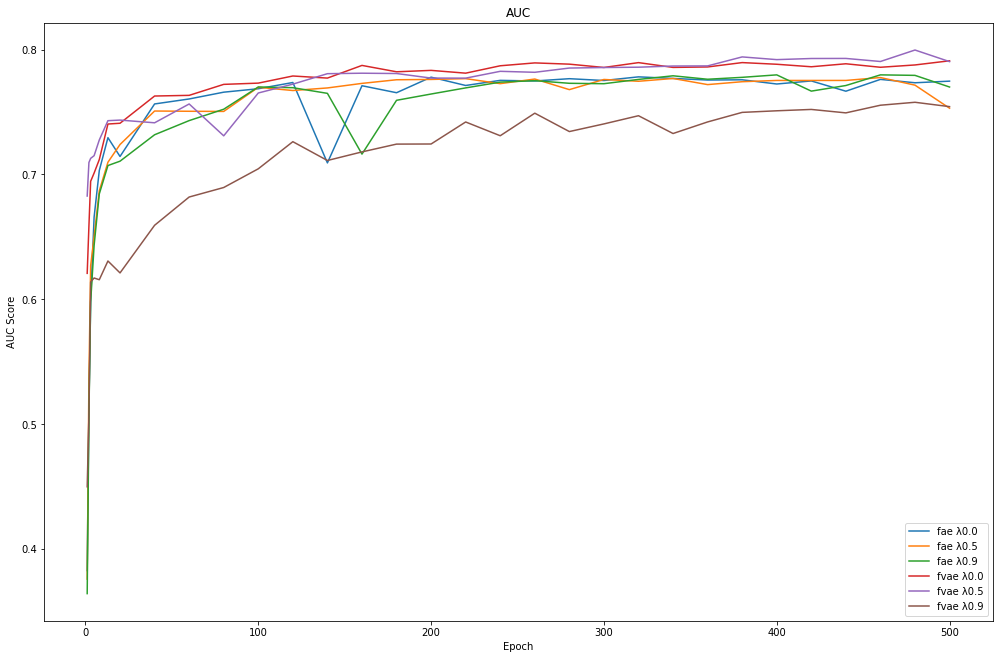

In [57]:
plt.rcParams["figure.figsize"] = (17,11)

plts = []
pltnames = []
for frill in tqdm(frills):
 for lmda in tqdm(lmdas, leave=False):
    pltnames += [f"f{frill} λ{lmda}"]
    plts+=[plt.plot(
            list(int(x[0]) for x in aucs[frill][lmda]["auc"]),
            list(float(x[1]) for x in aucs[frill][lmda]["auc"]),
        )]

plt.ylabel('AUC Score')
plt.xlabel('Epoch')
plt.legend(pltnames)
plt.title("AUC")
plt.show()